# Deep Learning

## Assignment 3

In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'notMNIST.pickle'
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [3]:
image_size = 28
num_labels = 10
def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

## Problem 1

### L2 regulization for logistic regression

In [5]:
batch_size = 128
#beta = 0.001

graph = tf.Graph()
with graph.as_default():
    #Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)
    
    #Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    #Training computation
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = logits)) + beta * tf.nn.l2_loss(weights)
    
    #Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    #Predictions for training, validation, test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [6]:
num_steps = 8001
beta_regu = 0.0005
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.log_device_placement = True

with tf.Session(graph = graph, config = tf_config)  as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        #Pick an offset within the training data.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        #Generate a minibatch
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size)]
        #feed dictionary
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta: beta_regu}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        if (step % 1000 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 15.955331
Minibatch accuracy: 7.8%
Validation accuracy: 12.3%
Minibatch loss at step 1000: 1.906889
Minibatch accuracy: 75.8%
Validation accuracy: 77.8%
Minibatch loss at step 2000: 1.044413
Minibatch accuracy: 79.7%
Validation accuracy: 79.4%
Minibatch loss at step 3000: 0.721229
Minibatch accuracy: 86.7%
Validation accuracy: 81.7%
Minibatch loss at step 4000: 0.970438
Minibatch accuracy: 74.2%
Validation accuracy: 80.3%
Minibatch loss at step 5000: 0.613207
Minibatch accuracy: 82.0%
Validation accuracy: 82.2%
Minibatch loss at step 6000: 0.747775
Minibatch accuracy: 79.7%
Validation accuracy: 82.5%
Minibatch loss at step 7000: 0.529374
Minibatch accuracy: 82.8%
Validation accuracy: 81.5%
Minibatch loss at step 8000: 0.590559
Minibatch accuracy: 82.0%
Validation accuracy: 81.9%
Test accuracy: 88.5%


### Tune the beta of regularization

In [7]:
num_steps = 8001
betas_regu = [pow(10, i) for i in np.arange(-5, -2, 0.1)]
accuracy_val = []
for beta_regu in betas_regu:
    with tf.Session(graph = graph, config = tf_config)  as session:
        tf.global_variables_initializer().run()
        print('Initialized when beta = %.6f' % beta_regu)
        for step in range(num_steps):
            #Pick an offset within the training data.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            #Generate a minibatch
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size)]
            #feed dictionary
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta: beta_regu}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))
        print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized when beta = 0.000010
Initialized when beta = 0.000013
Initialized when beta = 0.000016
Initialized when beta = 0.000020
Initialized when beta = 0.000025
Initialized when beta = 0.000032
Initialized when beta = 0.000040
Initialized when beta = 0.000050
Initialized when beta = 0.000063
Initialized when beta = 0.000079
Initialized when beta = 0.000100
Initialized when beta = 0.000126
Initialized when beta = 0.000158
Initialized when beta = 0.000200
Initialized when beta = 0.000251
Initialized when beta = 0.000316
Initialized when beta = 0.000398
Initialized when beta = 0.000501
Initialized when beta = 0.000631
Initialized when beta = 0.000794
Initialized when beta = 0.001000
Initialized when beta = 0.001259
Initialized when beta = 0.001585
Initialized when beta = 0.001995
Initialized when beta = 0.002512
Initialized when beta = 0.003162
Initialized when beta = 0.003981
Initialized when beta = 0.005012
Initialized when beta = 0.006310
Initialized when beta = 0.007943


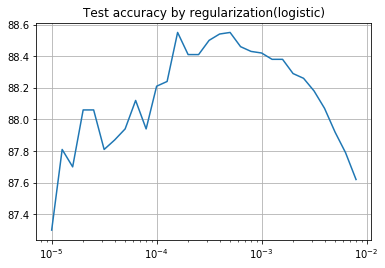

In [8]:
plt.semilogx(betas_regu, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization(logistic)')
plt.show()

### L2 regulization for neural network

In [9]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    #Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)
    
    #Variables.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    
    #Training computation.
    layer_1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
    layer_2 = tf.matmul(layer_1, weights_2) + biases_2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = layer_2)) + \
    beta * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2))
    
    #Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    #Predictions for the training, validation, testing data.
    train_prediction = tf.nn.softmax(layer_2)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1), weights_2) + biases_2)
    test_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1), weights_2) + biases_2)

In [10]:
num_steps =8001
beta_regu = 0.00025

with tf.Session(graph = graph, config = tf_config) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        #Pick an offset within training data.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        #Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        #Prapare feed dictionary.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta: beta_regu}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        if (step % 1000 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 432.311523
Minibatch accuracy: 10.2%
Validation accuracy: 30.4%
Minibatch loss at step 1000: 64.961746
Minibatch accuracy: 82.8%
Validation accuracy: 82.1%
Minibatch loss at step 2000: 47.180592
Minibatch accuracy: 85.9%
Validation accuracy: 81.8%
Minibatch loss at step 3000: 36.066849
Minibatch accuracy: 85.2%
Validation accuracy: 83.7%
Minibatch loss at step 4000: 28.925669
Minibatch accuracy: 77.3%
Validation accuracy: 82.6%
Minibatch loss at step 5000: 21.541218
Minibatch accuracy: 91.4%
Validation accuracy: 86.0%
Minibatch loss at step 6000: 17.019030
Minibatch accuracy: 86.7%
Validation accuracy: 86.4%
Minibatch loss at step 7000: 13.092662
Minibatch accuracy: 96.1%
Validation accuracy: 86.7%
Minibatch loss at step 8000: 10.455079
Minibatch accuracy: 90.6%
Validation accuracy: 87.4%
Test accuracy: 93.6%


In [11]:
accuracy_val = []
for beta_regu in betas_regu:
    with tf.Session(graph = graph, config = tf_config)  as session:
        tf.global_variables_initializer().run()
        print('Initialized when beta = %.6f' % beta_regu)
        for step in range(num_steps):
            #Pick an offset within the training data.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            #Generate a minibatch
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size)]
            #feed dictionary
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta: beta_regu}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))
        print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized when beta = 0.000010
Initialized when beta = 0.000013
Initialized when beta = 0.000016
Initialized when beta = 0.000020
Initialized when beta = 0.000025
Initialized when beta = 0.000032
Initialized when beta = 0.000040
Initialized when beta = 0.000050
Initialized when beta = 0.000063
Initialized when beta = 0.000079
Initialized when beta = 0.000100
Initialized when beta = 0.000126
Initialized when beta = 0.000158
Initialized when beta = 0.000200
Initialized when beta = 0.000251
Initialized when beta = 0.000316
Initialized when beta = 0.000398
Initialized when beta = 0.000501
Initialized when beta = 0.000631
Initialized when beta = 0.000794
Initialized when beta = 0.001000
Initialized when beta = 0.001259
Initialized when beta = 0.001585
Initialized when beta = 0.001995
Initialized when beta = 0.002512
Initialized when beta = 0.003162
Initialized when beta = 0.003981
Initialized when beta = 0.005012
Initialized when beta = 0.006310
Initialized when beta = 0.007943


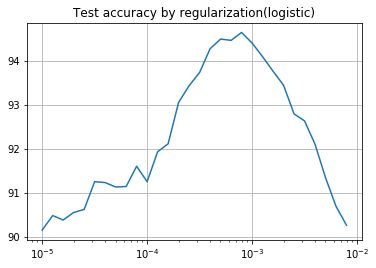

In [12]:
plt.semilogx(betas_regu, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization(logistic)')
plt.show()

## Problem 2

### Overfitting

In [13]:
num_steps =201
beta_regu = 0.00025

with tf.Session(graph = graph, config = tf_config) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        #Pick an offset within training data.
        #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        offset = step % batch_size
        #Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        #Prapare feed dictionary.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta: beta_regu}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        if (step % 10 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 392.922546
Minibatch accuracy: 15.6%
Validation accuracy: 39.1%
Minibatch loss at step 10: 80.139221
Minibatch accuracy: 99.2%
Validation accuracy: 64.2%
Minibatch loss at step 20: 81.841568
Minibatch accuracy: 99.2%
Validation accuracy: 64.1%
Minibatch loss at step 30: 78.050713
Minibatch accuracy: 100.0%
Validation accuracy: 65.9%
Minibatch loss at step 40: 77.856049
Minibatch accuracy: 100.0%
Validation accuracy: 65.8%
Minibatch loss at step 50: 77.659340
Minibatch accuracy: 100.0%
Validation accuracy: 65.3%
Minibatch loss at step 60: 77.455856
Minibatch accuracy: 100.0%
Validation accuracy: 68.5%
Minibatch loss at step 70: 77.260025
Minibatch accuracy: 100.0%
Validation accuracy: 68.6%
Minibatch loss at step 80: 77.066818
Minibatch accuracy: 100.0%
Validation accuracy: 68.4%
Minibatch loss at step 90: 76.873474
Minibatch accuracy: 100.0%
Validation accuracy: 69.0%
Minibatch loss at step 100: 76.682503
Minibatch accuracy: 100.0%
Validation accur

## Problem 3

### Dropout

In [14]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    #Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    #Variables.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    
    #Training computation.
    layer_1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
    layer_2 = tf.matmul(tf.nn.dropout(layer_1, 0.5), weights_2) + biases_2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = layer_2))
    
    #Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    #Predictions for the training, validation, testing data.
    train_prediction = tf.nn.softmax(layer_2)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1), weights_2) + biases_2)
    test_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1), weights_2) + biases_2)

In [15]:
num_steps =8001

with tf.Session(graph = graph, config = tf_config) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        #Pick an offset within training data.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        #Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        #Prapare feed dictionary.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        if (step % 1000 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 454.303131
Minibatch accuracy: 12.5%
Validation accuracy: 28.3%
Minibatch loss at step 1000: 13.865479
Minibatch accuracy: 68.0%
Validation accuracy: 79.4%
Minibatch loss at step 2000: 9.115481
Minibatch accuracy: 75.8%
Validation accuracy: 78.9%
Minibatch loss at step 3000: 4.028487
Minibatch accuracy: 76.6%
Validation accuracy: 80.2%
Minibatch loss at step 4000: 7.124763
Minibatch accuracy: 60.9%
Validation accuracy: 80.3%
Minibatch loss at step 5000: 2.127897
Minibatch accuracy: 75.0%
Validation accuracy: 80.9%
Minibatch loss at step 6000: 3.303937
Minibatch accuracy: 75.0%
Validation accuracy: 81.8%
Minibatch loss at step 7000: 1.691424
Minibatch accuracy: 78.1%
Validation accuracy: 82.2%
Minibatch loss at step 8000: 2.442971
Minibatch accuracy: 78.9%
Validation accuracy: 82.1%
Test accuracy: 89.1%


In [17]:
num_steps =201
beta_regu = 0.00025

with tf.Session(graph = graph, config = tf_config) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        #Pick an offset within training data.
        #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        offset = step % batch_size
        #Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        #Prapare feed dictionary.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        if (step % 10 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 544.890747
Minibatch accuracy: 9.4%
Validation accuracy: 28.4%
Minibatch loss at step 10: 0.738104
Minibatch accuracy: 98.4%
Validation accuracy: 67.3%
Minibatch loss at step 20: 4.814124
Minibatch accuracy: 97.7%
Validation accuracy: 70.1%
Minibatch loss at step 30: 7.901539
Minibatch accuracy: 93.8%
Validation accuracy: 68.0%
Minibatch loss at step 40: 1.159963
Minibatch accuracy: 98.4%
Validation accuracy: 68.9%
Minibatch loss at step 50: 2.068134
Minibatch accuracy: 98.4%
Validation accuracy: 69.7%
Minibatch loss at step 60: 2.535696
Minibatch accuracy: 99.2%
Validation accuracy: 69.2%
Minibatch loss at step 70: 2.595469
Minibatch accuracy: 96.1%
Validation accuracy: 70.6%
Minibatch loss at step 80: 9.512283
Minibatch accuracy: 96.9%
Validation accuracy: 70.5%
Minibatch loss at step 90: 2.986710
Minibatch accuracy: 97.7%
Validation accuracy: 70.5%
Minibatch loss at step 100: 3.764192
Minibatch accuracy: 97.7%
Validation accuracy: 71.0%
Minibatc

## Problem 4

### 2-layer network with L_2 regularization

In [18]:
batch_size = 128
num_hidden_nodes_1 = 1024
num_hidden_nodes_2 = 512

graph = tf.Graph()
with graph.as_default():
    #Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)
    
    #Variables.
    global_step = tf.Variable(0) #count the number of the steps taken.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes_1], 
                                               stddev = np.sqrt(2.0 / (image_size * image_size))))
    biases_1 = tf.Variable(tf.zeros([num_hidden_nodes_1]))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden_nodes_1, num_hidden_nodes_2], 
                                               stddev = np.sqrt(2.0 / num_hidden_nodes_1)))
    biases_2 = tf.Variable(tf.zeros([num_hidden_nodes_2]))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_nodes_2, num_labels], 
                                               stddev = np.sqrt(2.0 / num_hidden_nodes_2)))
    biases_3 = tf.Variable(tf.zeros([num_labels]))
    
    #Training computation.
    layer_1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
    layer_2 = tf.nn.relu(tf.matmul(layer_1, weights_2) + biases_2)
    logits = tf.matmul(layer_2, weights_3) + biases_3
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = logits)) + \
    beta * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + tf.nn.l2_loss(weights_3))
    
    #Optimizer.
    learning_rate = tf.train.exponential_decay(1.0, global_step, 10000, 0.96, staircase = True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step = global_step)
    
    #Predictions for the training, validation, testing data.
    train_prediction = tf.nn.softmax(logits)
    
    layer_1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
    layer_2_valid = tf.nn.relu(tf.matmul(layer_1_valid, weights_2) + biases_2)
    logits_valid = tf.matmul(layer_2_valid, weights_3) + biases_3
    valid_prediction = tf.nn.softmax(logits_valid)
    
    layer_1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
    layer_2_test = tf.nn.relu(tf.matmul(layer_1_test, weights_2) + biases_2)
    logits_test = tf.matmul(layer_2_test, weights_3) + biases_3
    test_prediction = tf.nn.softmax(logits_test)

In [19]:
num_steps = 15001
beta_regu = 0.00025

with tf.Session(graph = graph, config = tf_config) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        #Pick an offset within training data.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        #Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        #Prapare feed dictionary.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta: beta_regu}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        if (step % 1000 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.593975
Minibatch accuracy: 19.5%
Validation accuracy: 36.3%
Minibatch loss at step 1000: 0.637714
Minibatch accuracy: 87.5%
Validation accuracy: 87.2%
Minibatch loss at step 2000: 0.534325
Minibatch accuracy: 88.3%
Validation accuracy: 88.4%
Minibatch loss at step 3000: 0.467612
Minibatch accuracy: 91.4%
Validation accuracy: 87.8%
Minibatch loss at step 4000: 0.528750
Minibatch accuracy: 87.5%
Validation accuracy: 88.3%
Minibatch loss at step 5000: 0.432336
Minibatch accuracy: 89.1%
Validation accuracy: 89.5%
Minibatch loss at step 6000: 0.452103
Minibatch accuracy: 89.8%
Validation accuracy: 89.7%
Minibatch loss at step 7000: 0.249789
Minibatch accuracy: 96.9%
Validation accuracy: 89.2%
Minibatch loss at step 8000: 0.451486
Minibatch accuracy: 88.3%
Validation accuracy: 88.8%
Minibatch loss at step 9000: 0.449156
Minibatch accuracy: 89.8%
Validation accuracy: 89.3%
Minibatch loss at step 10000: 0.418494
Minibatch accuracy: 91.4%
Validation accur

In [20]:
accuracy_val = []
for beta_regu in betas_regu:
    with tf.Session(graph = graph, config = tf_config)  as session:
        tf.global_variables_initializer().run()
        print('Initialized when beta = %.6f' % beta_regu)
        for step in range(num_steps):
            #Pick an offset within the training data.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            #Generate a minibatch
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size)]
            #feed dictionary
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta: beta_regu}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))
        print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized when beta = 0.000010
Test accuracy: 94.7%
Initialized when beta = 0.000013
Test accuracy: 95.0%
Initialized when beta = 0.000016
Test accuracy: 94.2%
Initialized when beta = 0.000020
Test accuracy: 95.2%
Initialized when beta = 0.000025
Test accuracy: 95.2%
Initialized when beta = 0.000032
Test accuracy: 95.1%
Initialized when beta = 0.000040
Test accuracy: 95.1%
Initialized when beta = 0.000050
Test accuracy: 94.7%
Initialized when beta = 0.000063
Test accuracy: 94.9%
Initialized when beta = 0.000079
Test accuracy: 94.9%
Initialized when beta = 0.000100
Test accuracy: 95.0%
Initialized when beta = 0.000126
Test accuracy: 94.5%
Initialized when beta = 0.000158
Test accuracy: 93.4%
Initialized when beta = 0.000200
Test accuracy: 95.3%
Initialized when beta = 0.000251
Test accuracy: 94.5%
Initialized when beta = 0.000316
Test accuracy: 94.8%
Initialized when beta = 0.000398
Test accuracy: 94.8%
Initialized when beta = 0.000501
Test accuracy: 94.5%
Initialized when beta = 0.00

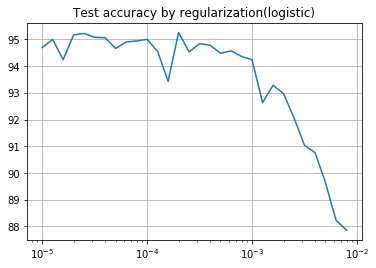

In [21]:
plt.semilogx(betas_regu, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization(logistic)')
plt.show()

### 5-layer network with L_2 regularization

In [22]:
batch_size = 512
num_hidden_nodes_1 = 1024
num_hidden_nodes_2 = 512
num_hidden_nodes_3 = 256
num_hidden_nodes_4 = 128
num_hidden_nodes_5 = 64

graph = tf.Graph()
with graph.as_default():
    #Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)
    
    #Variables.
    global_step = tf.Variable(0) #count the number of the steps taken.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes_1], 
                                               stddev = np.sqrt(2.0 / (image_size * image_size))))
    biases_1 = tf.Variable(tf.zeros([num_hidden_nodes_1]))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden_nodes_1, num_hidden_nodes_2], 
                                               stddev = np.sqrt(2.0 / num_hidden_nodes_1)))
    biases_2 = tf.Variable(tf.zeros([num_hidden_nodes_2]))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_nodes_2, num_hidden_nodes_3], 
                                               stddev = np.sqrt(2.0 / num_hidden_nodes_2)))
    biases_3 = tf.Variable(tf.zeros([num_hidden_nodes_3]))
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_nodes_3, num_hidden_nodes_4], 
                                               stddev = np.sqrt(2.0 / num_hidden_nodes_3)))
    biases_4 = tf.Variable(tf.zeros([num_hidden_nodes_4]))
    weights_5 = tf.Variable(tf.truncated_normal([num_hidden_nodes_4, num_hidden_nodes_5], 
                                               stddev = np.sqrt(2.0 / num_hidden_nodes_4)))
    biases_5 = tf.Variable(tf.zeros([num_hidden_nodes_5]))
    weights_6 = tf.Variable(tf.truncated_normal([num_hidden_nodes_5, num_labels], 
                                               stddev = np.sqrt(2.0 / num_hidden_nodes_5)))
    biases_6 = tf.Variable(tf.zeros([num_labels]))
    
    #Training computation.
    layer_1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
    layer_2 = tf.nn.relu(tf.matmul(layer_1, weights_2) + biases_2)
    layer_3 = tf.nn.relu(tf.matmul(layer_2, weights_3) + biases_3)
    layer_4 = tf.nn.relu(tf.matmul(layer_3, weights_4) + biases_4)
    layer_5 = tf.nn.relu(tf.matmul(layer_4, weights_5) + biases_5)
    logits = tf.matmul(layer_5, weights_6) + biases_6
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = logits)) + \
    beta * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + tf.nn.l2_loss(weights_3) + \
           tf.nn.l2_loss(weights_4) + tf.nn.l2_loss(weights_5) + tf.nn.l2_loss(weights_6))
    
    #Optimizer.
    learning_rate = tf.train.exponential_decay(1.0, global_step, 10000, 0.96, staircase = True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step = global_step)
    
    #Predictions for the training, validation, testing data.
    train_prediction = tf.nn.softmax(logits)
    
    layer_1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
    layer_2_valid = tf.nn.relu(tf.matmul(layer_1_valid, weights_2) + biases_2)
    layer_3_valid = tf.nn.relu(tf.matmul(layer_2_valid, weights_3) + biases_3)
    layer_4_valid = tf.nn.relu(tf.matmul(layer_3_valid, weights_4) + biases_4)
    layer_5_valid = tf.nn.relu(tf.matmul(layer_4_valid, weights_5) + biases_5)
    logits_valid = tf.matmul(layer_5_valid, weights_6) + biases_6
    valid_prediction = tf.nn.softmax(logits_valid)
    
    layer_1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
    layer_2_test = tf.nn.relu(tf.matmul(layer_1_test, weights_2) + biases_2)
    layer_3_test = tf.nn.relu(tf.matmul(layer_2_test, weights_3) + biases_3)
    layer_4_test = tf.nn.relu(tf.matmul(layer_3_test, weights_4) + biases_4)
    layer_5_test = tf.nn.relu(tf.matmul(layer_4_test, weights_5) + biases_5)
    logits_test = tf.matmul(layer_5_test, weights_6) + biases_6
    test_prediction = tf.nn.softmax(logits_test)

In [23]:
num_steps = 15001
beta_regu = 0.00025

with tf.Session(graph = graph, config = tf_config) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        #Pick an offset within training data.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        #Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        #Prapare feed dictionary.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta: beta_regu}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        if (step % 1000 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.707100
Minibatch accuracy: 10.2%
Validation accuracy: 30.4%
Minibatch loss at step 1000: 3.796994
Minibatch accuracy: 9.6%
Validation accuracy: 10.0%
Minibatch loss at step 2000: 3.207771
Minibatch accuracy: 10.7%
Validation accuracy: 10.0%
Minibatch loss at step 3000: 2.852569
Minibatch accuracy: 8.6%
Validation accuracy: 10.0%
Minibatch loss at step 4000: nan
Minibatch accuracy: 10.4%
Validation accuracy: 10.0%
Minibatch loss at step 5000: nan
Minibatch accuracy: 9.8%
Validation accuracy: 10.0%
Minibatch loss at step 6000: nan
Minibatch accuracy: 9.6%
Validation accuracy: 10.0%
Minibatch loss at step 7000: nan
Minibatch accuracy: 11.3%
Validation accuracy: 10.0%
Minibatch loss at step 8000: nan
Minibatch accuracy: 8.8%
Validation accuracy: 10.0%
Minibatch loss at step 9000: nan
Minibatch accuracy: 9.6%
Validation accuracy: 10.0%
Minibatch loss at step 10000: nan
Minibatch accuracy: 8.2%
Validation accuracy: 10.0%
Minibatch loss at step 11000: n

In [24]:
accuracy_val = []
for beta_regu in betas_regu:
    with tf.Session(graph = graph, config = tf_config)  as session:
        tf.global_variables_initializer().run()
        print('Initialized when beta = %.6f' % beta_regu)
        for step in range(num_steps):
            #Pick an offset within the training data.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            #Generate a minibatch
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size)]
            #feed dictionary
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta: beta_regu}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))
        print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized when beta = 0.000010
Test accuracy: 96.1%
Initialized when beta = 0.000013
Test accuracy: 10.0%
Initialized when beta = 0.000016
Test accuracy: 96.1%
Initialized when beta = 0.000020
Test accuracy: 10.0%
Initialized when beta = 0.000025
Test accuracy: 95.9%
Initialized when beta = 0.000032
Test accuracy: 10.0%
Initialized when beta = 0.000040
Test accuracy: 10.0%
Initialized when beta = 0.000050
Test accuracy: 10.0%
Initialized when beta = 0.000063
Test accuracy: 10.0%
Initialized when beta = 0.000079
Test accuracy: 10.0%
Initialized when beta = 0.000100
Test accuracy: 10.0%
Initialized when beta = 0.000126
Test accuracy: 10.0%
Initialized when beta = 0.000158
Test accuracy: 10.0%
Initialized when beta = 0.000200
Test accuracy: 10.0%
Initialized when beta = 0.000251
Test accuracy: 10.0%
Initialized when beta = 0.000316
Test accuracy: 10.0%
Initialized when beta = 0.000398
Test accuracy: 10.0%
Initialized when beta = 0.000501
Test accuracy: 10.0%
Initialized when beta = 0.00

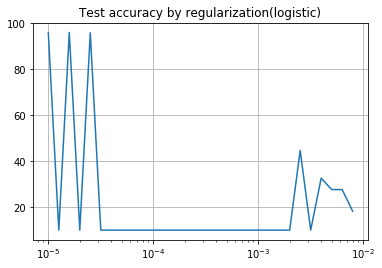

In [25]:
plt.semilogx(betas_regu, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization(logistic)')
plt.show()